# QCBM-based Path Simulation
Based on papers: https://arxiv.org/pdf/2204.06150, https://arxiv.org/html/2405.11795v1#Sx2.F4


In [234]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


total_qubits = 8  
layers = 8  
dev = qml.device("default.qubit", wires=total_qubits)




def variational_circuit(params):
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.probs(wires=range(total_qubits))

def brick_ansatz(params):
    """Standard Brick Wall QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly QCBM with logarithmic-depth global entanglement."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid QCBM: Progressive entanglement with increasing layer depth."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement QCBM."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement QCBM with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))




def rbs_gate(theta, wires):
    """Implements the RBS gate as a combination of Ry and CZ gates."""
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=wires)
    qml.RY(-theta, wires=wires[0])
    qml.CNOT(wires=wires)

def pyramid_ansatz(params):
    """Pyramid structured QCBM using RBS gates."""
    qubits = params.shape[1]  
    for l in range(params.shape[0]):  
        step = 1
        while step < qubits:
            for i in range(0, qubits - step, 2 * step):
                rbs_gate(params[l, i, 0], wires=[i, i + step])
            step *= 2  # Increase step size in powers of 2
    return qml.probs(wires=range(qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return pyramid_ansatz(params)


In [235]:
def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(params):
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)


def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('StoxxLarger.csv')


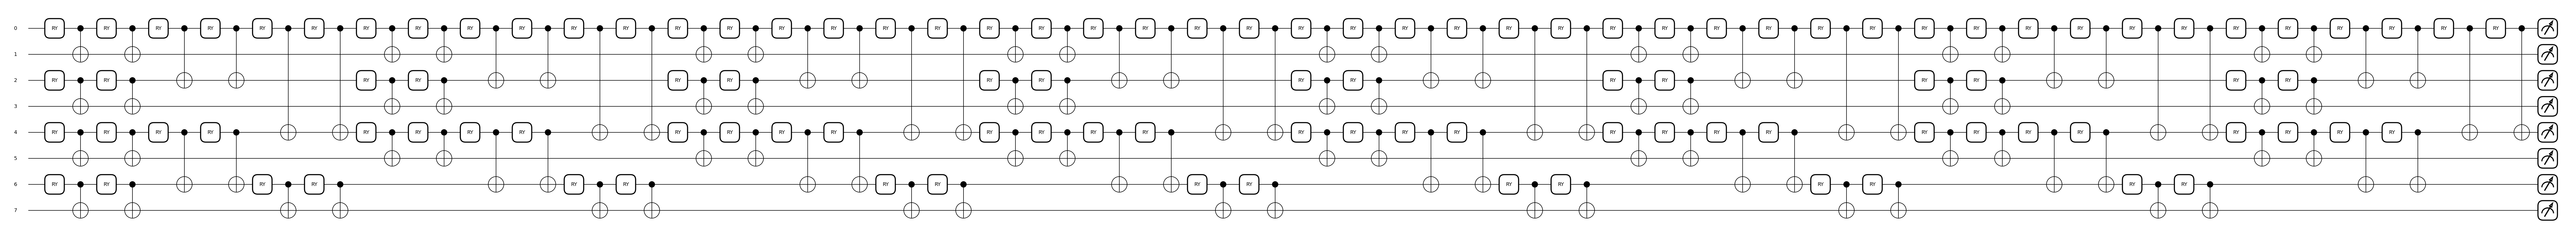

In [236]:
opt = qml.AdamOptimizer(stepsize=0.05)
params = pnp.array(np.random.uniform(0, np.pi, (layers, total_qubits, 3)), requires_grad=True)

qml.draw_mpl(quantum_model)(params)
plt.show()



In [ ]:
steps_training = 20

for i in range(steps_training):
    params = opt.step(cost, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost(params)}")

  

def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    #print(qml.draw(quantum_probs))
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]

Step 0: Cost = 2.7333819555241483


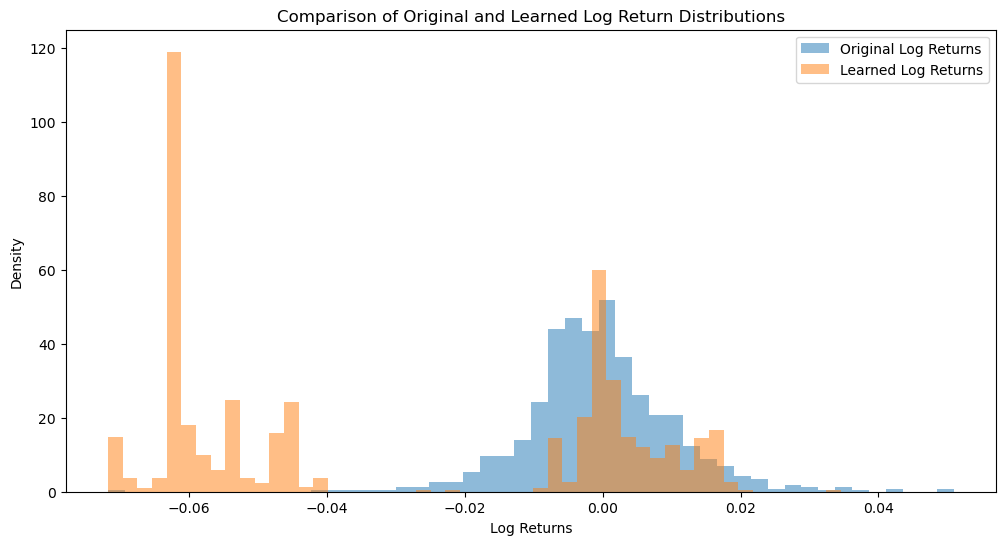

In [ ]:
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

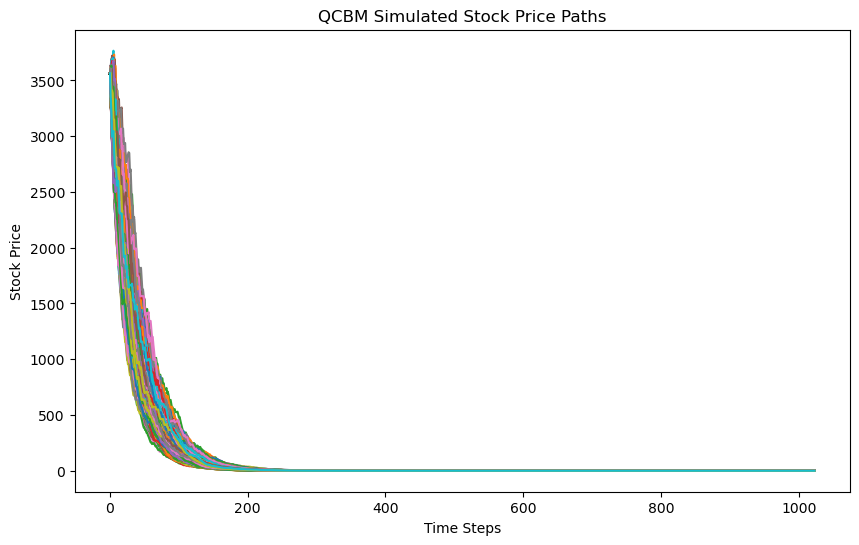

In [ ]:


def simulate_stochastic_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 3564.63  # Starting value
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

# Propagate the learned stochastic process
def propagate_stochastic_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_stochastic_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


num_paths = 1000
steps = 256*4
paths = propagate_stochastic_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

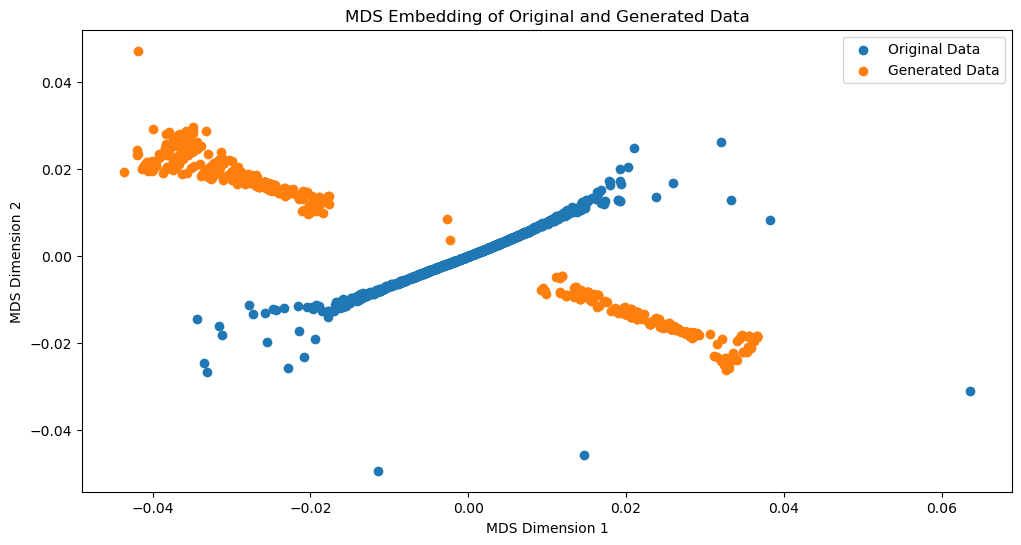

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

original_distances = pairwise_distances(log_returns.reshape(-1, 1))
generated_distances = pairwise_distances(synthetic_log_returns.reshape(-1, 1))

mds = MDS(n_components=2, dissimilarity='precomputed')
original_mds = mds.fit_transform(original_distances)
generated_mds = mds.fit_transform(generated_distances)

plt.figure(figsize=(12, 6))
plt.scatter(original_mds[:, 0], original_mds[:, 1], label='Original Data')
plt.scatter(generated_mds[:, 0], generated_mds[:, 1], label='Generated Data')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Embedding of Original and Generated Data')
plt.legend()

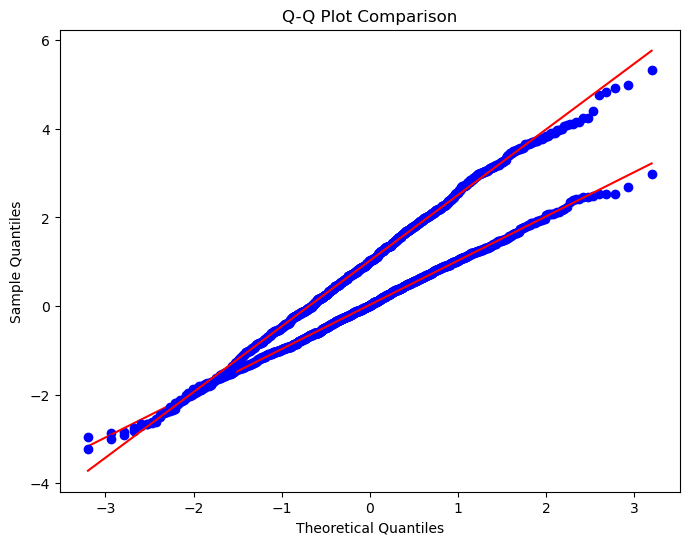

In [ ]:
import scipy.stats as stats

real_data = np.random.normal(loc=0, scale=1, size=1000)
quantum_generated_data = np.random.normal(loc=1, scale=1.5, size=1000)

plt.figure(figsize=(8, 6))
stats.probplot(real_data, dist="norm", plot=plt)
stats.probplot(quantum_generated_data, dist="norm", plot=plt)

plt.xlabel('Quantum Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot Comparison')
plt.show()